# COMPAS Recidivism

The COMPAS dataset consists of the results of a commercial algorithm called COMPAS (Correctional Offender Management 
Profiling for Alternative Sanctions), used to assess a convicted criminal's likelihood of reoffending.
COMPAS has been used by judges and parole officers and is widely known for its bias against African-Americans.


In this notebook, we will use `fairlens` to explore the COMPAS dataset for bias toward legally protected
features. We will go on to show similar biases in a logistic regressor trained to forecast a criminal's risk of
reoffending using the dataset. [1]

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import fairlens as fl
import matplotlib.pyplot as plt
from itertools import combinations, chain
from sklearn.linear_model import LogisticRegression

# Load in the 2 year COMPAS Recidivism dataset
df = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv")
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


The analysis done by ProPublica suggests that certain cases may have had alternative reasons for being charged [1].
We will drop such rows which are not usable.

In [2]:
df = df[(df["days_b_screening_arrest"] <= 30)
        & (df["days_b_screening_arrest"] >= -30)
        & (df["is_recid"] != -1)
        & (df["c_charge_degree"] != 'O')
        & (df["score_text"] != 'N/A')].reset_index(drop=True)

df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
4,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
6168,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
6169,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
6170,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


## Analysis

We'll begin by identifying the legally protected attributes in the data. `fairlens` detects these using
using fuzzy matching on the column names and values to a custom preset of expected values. 

In [3]:
# Detect sensitive attributes
sensitive_attributes = fl.sensitive.detect_names_df(df, deep_search=True)
print(sensitive_attributes)
print(sensitive_attributes.keys())

{'sex': 'Gender', 'dob': 'Age', 'age': 'Age', 'race': 'Ethnicity'}
dict_keys(['sex', 'dob', 'age', 'race'])


We can see that the attributes that we should be concerned about correspond to gender, age and ethnicity.

In [4]:
df[["sex", "race", "age", "dob", "age_cat", "decile_score"]].head()

,sex,race,age,dob,age_cat,decile_score
0,Male,Other,69,1947-04-18,Greater than 45,1
1,Male,African-American,34,1982-01-22,25 - 45,3
2,Male,African-American,24,1991-05-14,Less than 25,4
3,Male,Other,44,1971-08-22,25 - 45,1
4,Male,Caucasian,41,1974-07-23,25 - 45,6


`fairlens` will discretize continuous sensitive attributes such as age to make the results more interpretable,
i.e. "Greater than 45", "25 - 45", "Less than 25" in the case of age. The COMPAS dataset comes with a categorical
column for age which we can use instead.

We can inspect potential biases in decile scores by visualizing the distributions of different sensitive
sub-groups in the data. Methods in `fairlens.plot` can be used to generate plots of distributions of variables
in different sub-groups in the data.

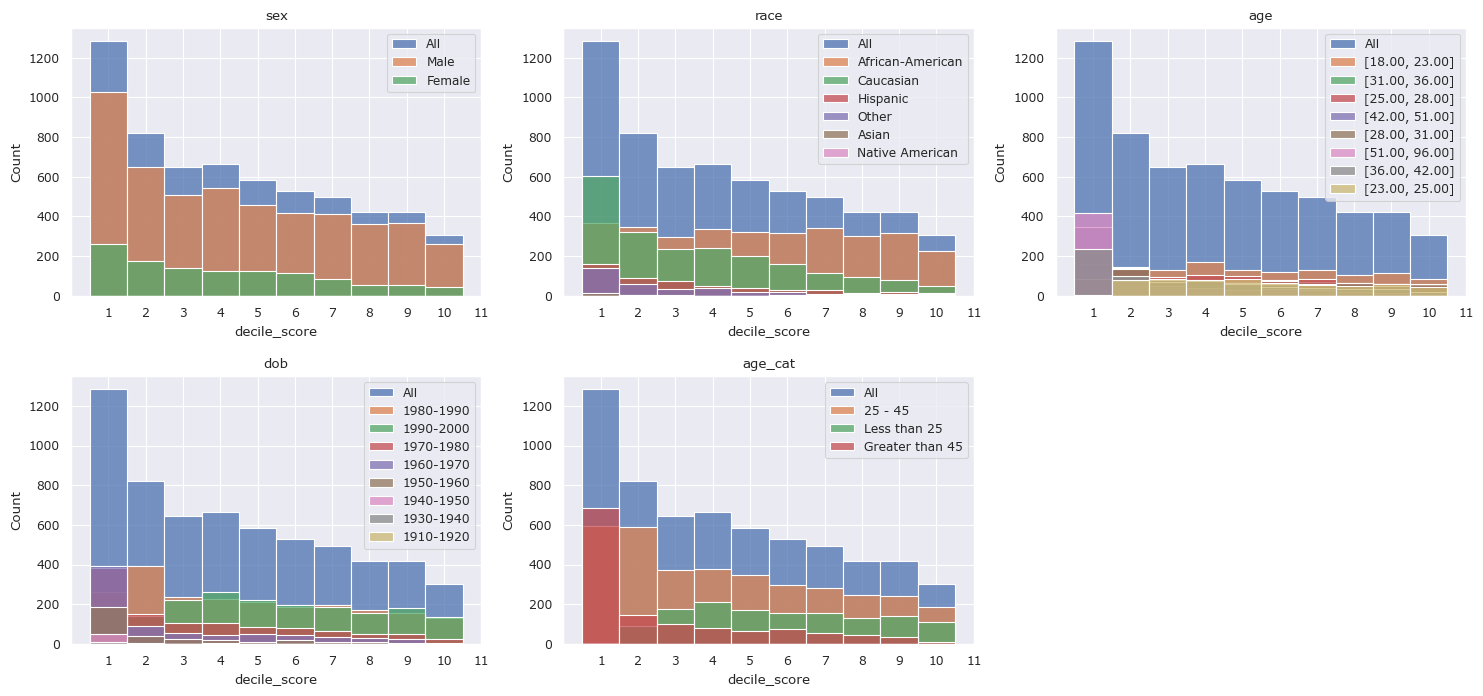

In [5]:
target_attribute = "decile_score"
sensitive_attributes = ["sex", "race", "age", "dob", "age_cat"]

# Set the seaborn style
fl.plot.use_style()

# Plot the distributions
fl.plot.mult_distr_plot(df, target_attribute, sensitive_attributes)
plt.show()

The largest horizontal disparity in scores seems to be in race, specifically between African-Americans and Caucasians,
who make up most of the sample. We can visualize or measure the distance between two arbitrary sub-groups using
predicates as shown below.

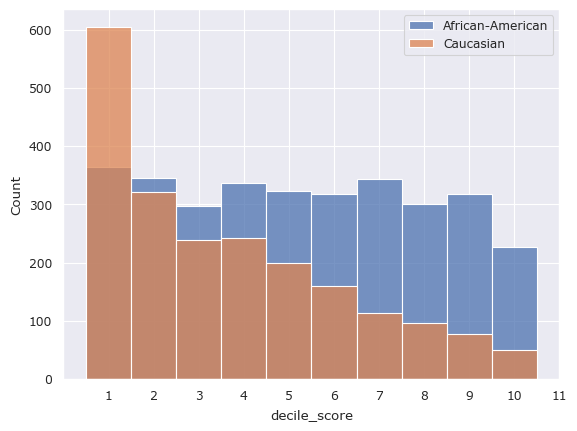

In [6]:
# Plot the distributions of decile scores in subgroups made of African-Americans and Caucasians
group1 = {"race": ["African-American"]}
group2 = {"race": ["Caucasian"]}

fl.plot.distr_plot(df, "decile_score", [group1, group2])
plt.legend(["African-American", "Caucasian"])
plt.show()

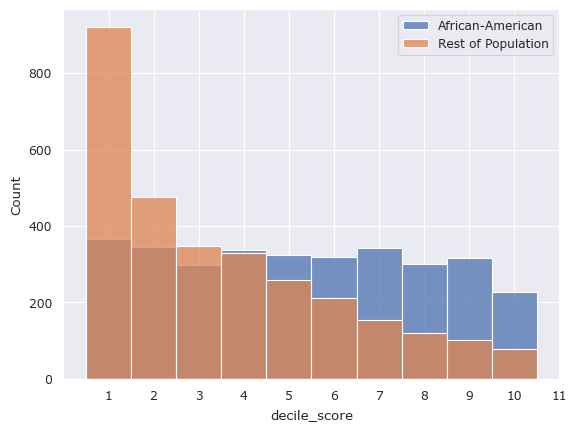

In [7]:
group1 = {"race": ["African-American"]}
group2 = df["race"] != "African-American"

fl.plot.distr_plot(df, "decile_score", [group1, group2])
plt.legend(["African-American", "Rest of Population"])
plt.show()

The above disparity by measuring statistical distances between the two distributions. Since the
the decile scores are categorical, metrics such as the Earth Mover's Distance, the LP-Norm, or the Hellinger Distance
would be useful. `fairlens.metrics` provides a `stat_distance` method which can be used to compute these metrics.

In [8]:
import fairlens.metrics as fm

group1 = {"race": ["African-American"]}
group2 = {"race": ["Caucasian"]}

distances = {}
for metric in ["emd", "norm", "hellinger"]:
    distances[metric] = fm.stat_distance(df, "decile_score", group1, group2, mode=metric)


pd.DataFrame.from_dict(distances, orient="index", columns=["distance"])

,distance
emd,0.245107
norm,0.210866
hellinger,0.214566


Measuring the statistical distance between the distribution of a variable in a subgroup and in the entire dataset
can indicate how biased the variable is with respect to the subgroup. We can use the `fl.FairnessScorer` class 
to compute this for each sub-group.

In [9]:
fscorer = fl.FairnessScorer(df, "decile_score", ["sex", "race", "age_cat"])
fscorer.distribution_score(max_comb=1, p_value=True)

,Group,Distance,Proportion,Counts,P-Value
0,Greater than 45,0.322188,0.209494,1293,0.54
1,25 - 45,0.042123,0.572262,3532,0.98
2,Less than 25,0.272500,0.218244,1347,0.53
3,Other,0.253175,0.055574,343,0.69
4,African-American,0.130340,0.514420,3175,0.54
5,Caucasian,0.115572,0.340732,2103,0.64
6,Hispanic,0.184277,0.082469,509,0.67
7,Asian,0.331973,0.005023,31,0.86
8,Native American,0.492532,0.001782,11,0.90
9,Male,0.016210,0.809624,4997,0.97


The method `fl.FairnessScorer.distribution_score()` makes use of suitable hypothesis tests to determine how different
the distribution of the decile scores is in each sensitive subgroup.

## Training a Model

Our above analysis has confirmed that there are inherent biases present in the COMPAS dataset. We now show the
result of training a model on the COMPAS dataset and using it to predict an unknown criminal's
likelihood of reoffending.

We use a logistic regressor trained on a subset of the features.

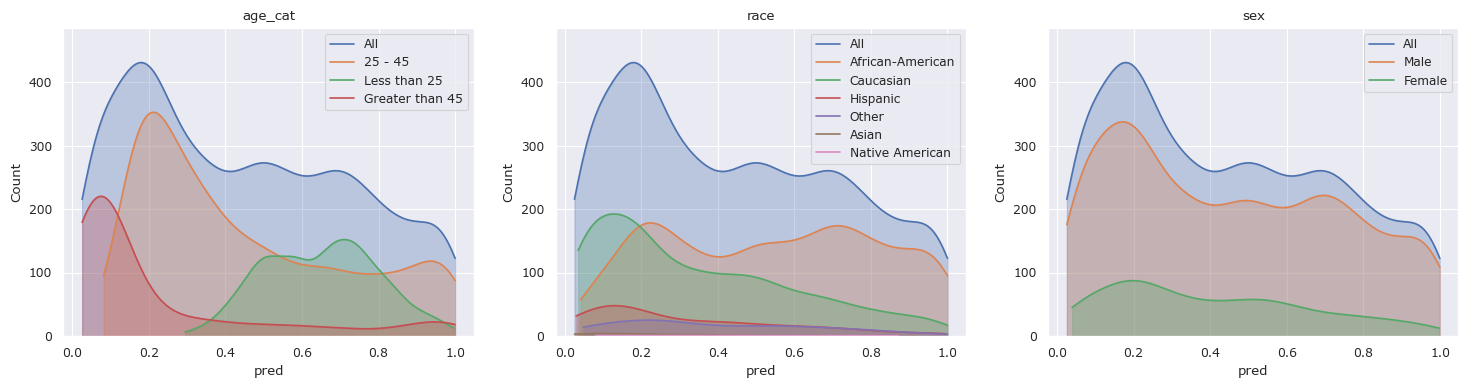

In [10]:
# Select the features to use
df = df[["sex", "race", "age_cat", "c_charge_degree", "priors_count", "two_year_recid", "score_text"]]

# Split the dataset into train and test
sp = int(len(df) * 0.8)
df_train = df[:sp].reset_index(drop=True)
df_test = df[sp:].reset_index(drop=True)

# Convert categorical columns to numerical columns
def preprocess(df):
    X = df.copy()
    X["sex"] = pd.factorize(df["sex"])[0]
    X["race"] = pd.factorize(df["race"])[0]
    X["age_cat"].replace(["Greater than 45", "25 - 45", "Less than 25"], [2, 1, 0], inplace=True)
    X["c_charge_degree"] = pd.factorize(df["c_charge_degree"])[0]
    X.drop(columns=["score_text"], inplace=True)
    X = X.to_numpy()

    y = pd.factorize(df["score_text"] != "Low")[0]

    return X, y

df_train = df[:sp].reset_index(drop=True)

# Train a regressor
X, y = preprocess(df_train)
clf = LogisticRegression(random_state=0).fit(X, y)

# Classify the training data
df_train["pred"] = clf.predict_proba(X)[:, 1]

# Plot the distributions
fscorer = fl.FairnessScorer(df_train, "pred", ["race", "sex", "age_cat"])
fscorer.plot_distributions()
plt.show()

In [11]:
X = df.copy()
X["sex"] = pd.factorize(df["sex"])[0]
X["race"] = pd.factorize(df["race"])[0]
X["age_cat"].replace(["Greater than 45", "25 - 45", "Less than 25"], [2, 1, 0], inplace=True)
X["c_charge_degree"] = pd.factorize(df["c_charge_degree"])[0]
X.drop(columns=["score_text"], inplace=True)

X.corr()

,sex,race,age_cat,c_charge_degree,priors_count,two_year_recid
sex,1.000000,0.025568,0.002701,0.061848,-0.118722,-0.100911
race,0.025568,1.000000,0.104551,0.078824,-0.123963,-0.088536
age_cat,0.002701,0.104551,1.000000,0.097368,0.169822,-0.156930
c_charge_degree,0.061848,0.078824,0.097368,1.000000,-0.145433,-0.120332
priors_count,-0.118722,-0.123963,0.169822,-0.145433,1.000000,0.290607
two_year_recid,-0.100911,-0.088536,-0.156930,-0.120332,0.290607,1.000000


Above, we see the distributions of the training predictions are similar to the distributions in the data from above.
Let's see the results on the held out test set.

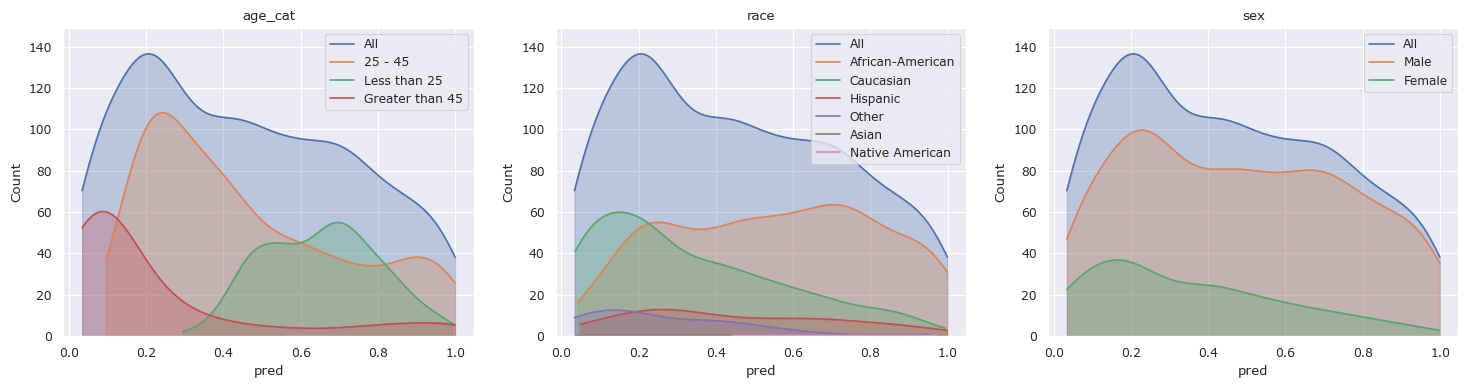

In [12]:
# Classify the test data
X, _ = preprocess(df_test)
df_test["pred"] = clf.predict_proba(X)[:, 1]

# Plot the distributions
fscorer = fl.FairnessScorer(df_test, "pred", ["race", "sex", "age_cat"])
fscorer.plot_distributions()
plt.show()

In [13]:
fscorer.distribution_score(max_comb=1, p_value=True).sort_values("Distance", ascending=False).reset_index(drop=True)

,Group,Distance,Proportion,Counts,P-Value
0,Native American,0.513360,0.002429,3,3.046032e-01
1,Greater than 45,0.495185,0.204858,253,7.771561e-16
2,Less than 25,0.456088,0.229150,283,3.005322e-44
3,Other,0.333459,0.059109,73,2.491168e-07
4,Asian,0.238664,0.003239,4,9.366481e-01
5,Caucasian,0.200244,0.324696,401,4.152367e-11
6,Female,0.175752,0.208907,258,3.079097e-06
7,African-American,0.166902,0.522267,645,8.779233e-11
8,25 - 45,0.117271,0.565992,699,8.242076e-06
9,Hispanic,0.082636,0.088259,109,4.743583e-01


Lets try training a model after dropping "race" from the model and look at the results.

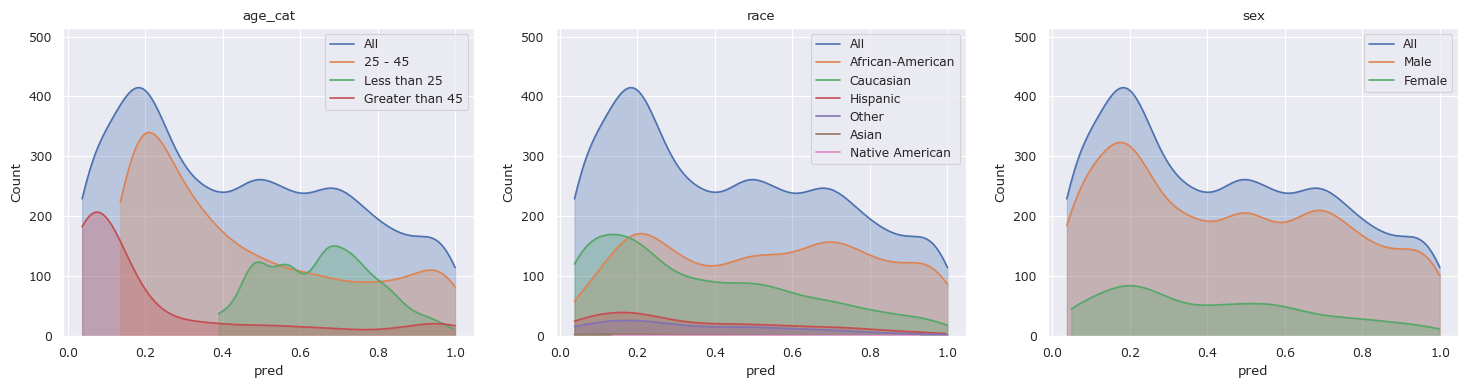

In [14]:
# Drop the predicted column before training again
df_train.drop(columns=["pred"], inplace=True)

# Preprocess he data and drop race
X, y = preprocess(df_train)
X = np.delete(X, df_train.columns.get_loc("race"), axis=1)

# Train a regressor and classify the training data
clf = LogisticRegression(random_state=0).fit(X, y)
df_train["pred"] = clf.predict_proba(X)[:, 1]

# Plot the distributions
fscorer = fl.FairnessScorer(df_train, "pred", ["race", "sex", "age_cat"])
fscorer.plot_distributions()
plt.show()

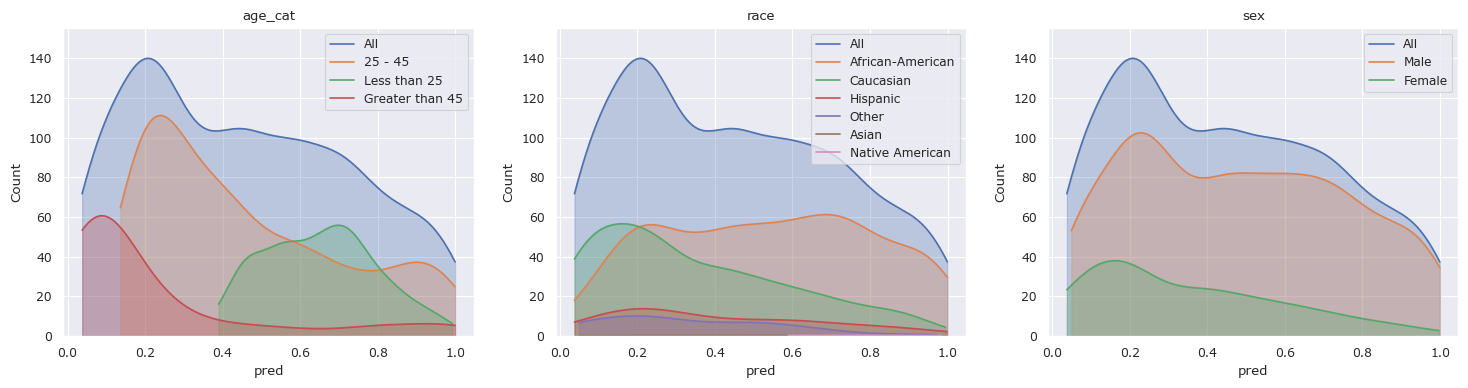

In [15]:
# Drop the predicted column before training again
df_test.drop(columns=["pred"], inplace=True)

# Classify the test data
X, _ = preprocess(df_test)
X = np.delete(X, df_test.columns.get_loc("race"), axis=1)

df_test["pred"] = clf.predict_proba(X)[:, 1]

# Plot the distributions
fscorer = fl.FairnessScorer(df_test, "pred", ["race", "sex", "age_cat"])
fscorer.plot_distributions()
plt.show()

In [16]:
fscorer.distribution_score(max_comb=1, p_value=True).sort_values("Distance", ascending=False).reset_index(drop=True)

,Group,Distance,Proportion,Counts,P-Value
0,Native American,0.672065,0.002429,3,7.123637e-02
1,Greater than 45,0.503900,0.204858,253,7.771561e-16
2,Less than 25,0.488846,0.229150,283,3.438215e-51
3,Asian,0.243927,0.003239,4,9.240617e-01
4,Other,0.211059,0.059109,73,3.564472e-03
5,Female,0.173141,0.208907,258,4.565218e-06
6,Caucasian,0.160895,0.324696,401,2.577566e-07
7,African-American,0.128776,0.522267,645,1.368363e-06
8,25 - 45,0.120753,0.565992,699,3.908314e-06
9,Hispanic,0.097017,0.088259,109,2.824348e-01


We can see that despite dropping the attribute "race", the biases toward people in different racial groups is relatively
unaffected.

## References

[1] Jeff Larson, Surya Mattu, Lauren Kirchner, and Julia Angwin. How we analyzed the compas recidivism algorithm. 2016. 
URL: <https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm.>